In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from sklearn.model_selection import LeaveOneOut, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from tqdm import tqdm

In [24]:
# Загрузка предобработанных данных
root = "../.."
input_path = f"{root}/data/processed"

scaled_coverage_data = pd.read_csv(f"{input_path}/scaled/coverage.csv")
encoded_coverage_data  = pd.read_csv(f"{input_path}/encoded/coverage.csv")
catboost_coverage_data = pd.read_csv(f"{input_path}/catboost/coverage.csv")

In [25]:
def evaluate_kfold(X, y, model, model_name, n_splits=10, cat_features=None):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_true, y_pred = [], []
    for tr, te in tqdm(kf.split(X), total=n_splits, desc=f"{model_name} {n_splits}-fold"):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]
        if cat_features and model_name.lower().startswith("catboost"):
            model.fit(X_tr, y_tr, cat_features=cat_features, verbose=False)
        else:
            model.fit(X_tr, y_tr)
        y_pred.extend(model.predict(X_te))
        y_true.extend(y_te.values)

    r2 = r2_score(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
    mn, mx = min(y_true), max(y_true)
    plt.plot([mn, mx], [mn, mx], 'k--', lw=2)
    plt.title(f"{model_name} — {n_splits}-fold\nR²: {r2:.3f} | RMSE: {rmse:.3f}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return r2, rmse

In [26]:
# Разделение признаков и целевой переменной
X_scaled = scaled_coverage_data.drop(columns=["experiment.results.coverage.value"])
y_scaled = scaled_coverage_data["experiment.results.coverage.value"]

X_encoded  = encoded_coverage_data .drop(columns=["experiment.results.coverage.value"])
y_encoded  = encoded_coverage_data ["experiment.results.coverage.value"]

X_catboost = catboost_coverage_data.drop(columns=["experiment.results.coverage.value"])
y_catboost = catboost_coverage_data["experiment.results.coverage.value"]

# Выделение категориальных признаков для CatBoost
catboost_features = X_catboost.select_dtypes(include=["object", "category"]).columns.tolist()
X_catboost[catboost_features] = X_catboost[catboost_features].fillna('nan')

results = {}

Linear Regression 10-fold: 100%|██████████| 10/10 [00:00<00:00, 86.94it/s]


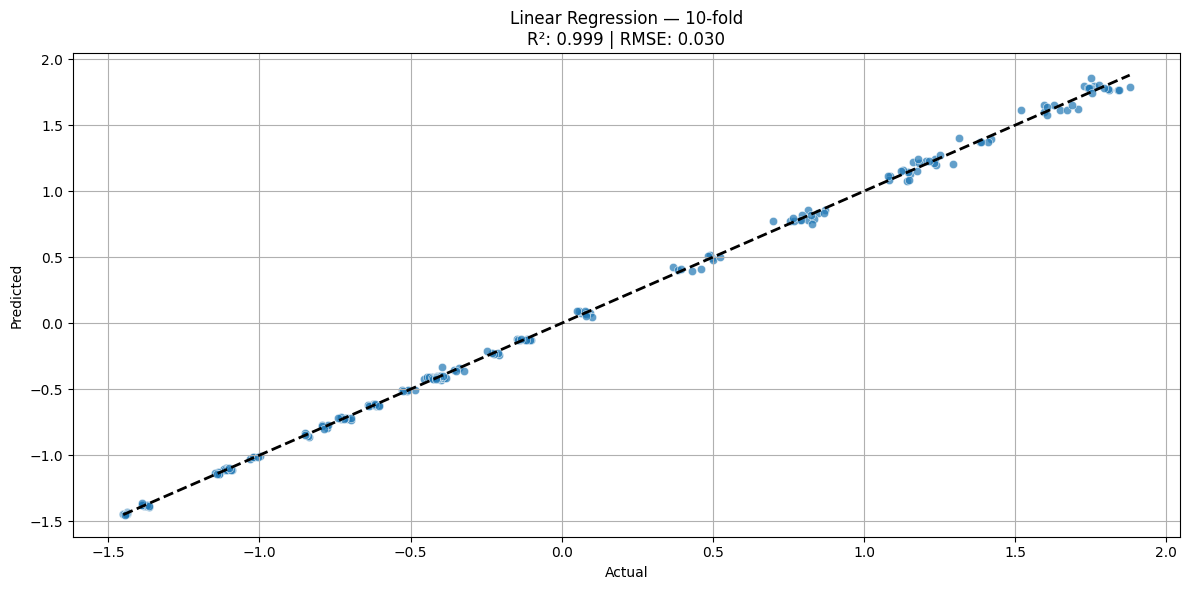

In [27]:
results["LinearRegression"] = evaluate_kfold(X_scaled, y_scaled, LinearRegression(), "Linear Regression")

In [28]:
# Подбор гиперпараметров для SVR
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': np.logspace(-2, 3, 6),        # 0.01, 0.1, 1, 10, 100, 1000
    'epsilon': np.logspace(-3, -1, 3), # 0.001, 0.01, 0.1
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 1, 5))  # scale, auto и значения от 0.001 до 10
}

# Кросс-валидация
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_scaled, y_scaled)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 10 folds for each of 504 candidates, totalling 5040 fits
Best parameters: {'C': np.float64(10.0), 'epsilon': np.float64(0.01), 'gamma': 'scale', 'kernel': 'linear'}
Best R2 score (KFold): 0.9990432438931854


In [29]:
# Подбор гиперпараметров для SVR
param_grid = {
    'kernel': ['linear'],
    'C': np.logspace(0, 2, 10),        
    'epsilon': np.logspace(-3, -1, 10),
    'gamma': ['scale']
}

# Кросс-валидация
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_scaled, y_scaled)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters: {'C': np.float64(21.544346900318832), 'epsilon': np.float64(0.007742636826811269), 'gamma': 'scale', 'kernel': 'linear'}
Best R2 score (KFold): 0.9990878179410627


SVR 10-fold: 100%|██████████| 10/10 [00:01<00:00,  5.10it/s]


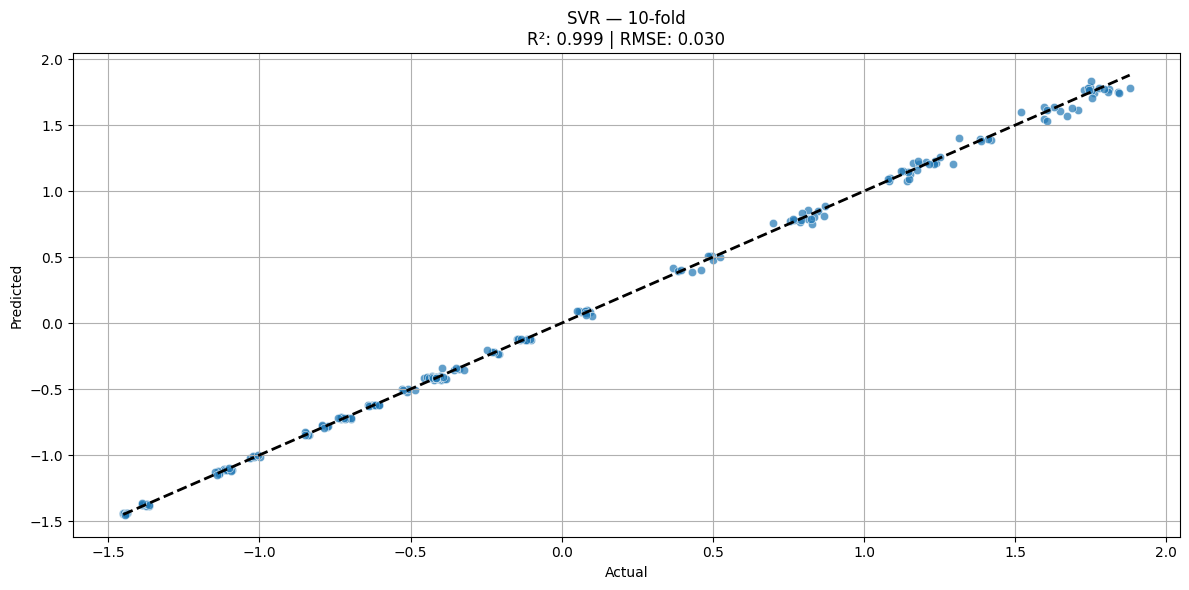

In [30]:
results["SVR"] = evaluate_kfold(X_scaled, y_scaled, SVR(**grid_search.best_params_), "SVR")

Random Forest 10-fold: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


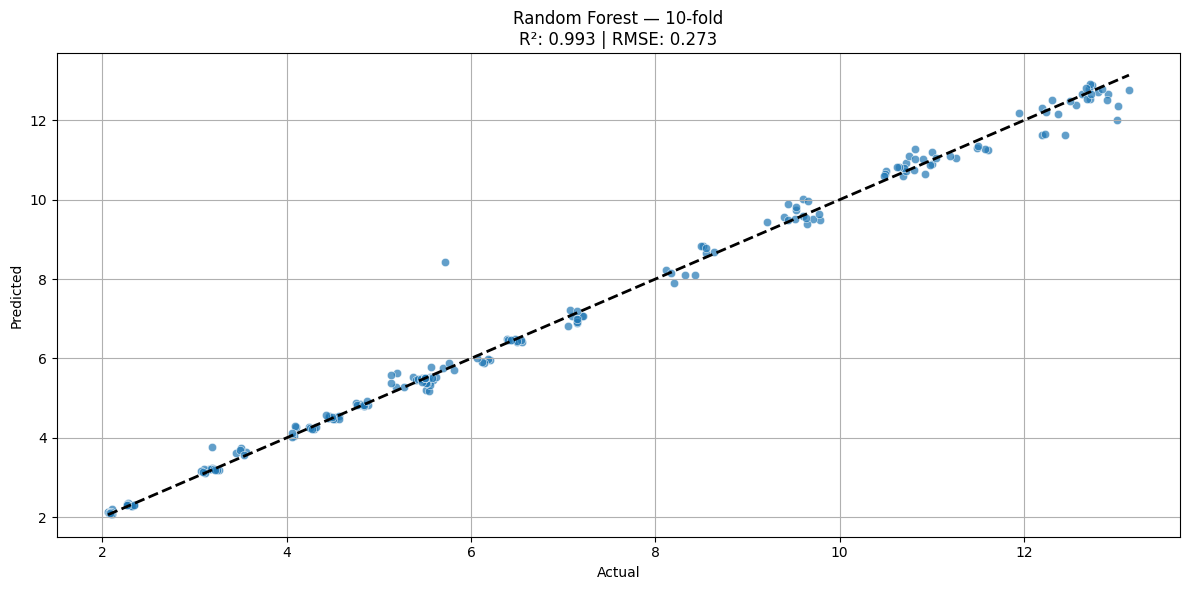

In [31]:
results["RandomForest"] = evaluate_kfold(X_encoded , y_encoded , RandomForestRegressor(), "Random Forest")

Gradient Boosting 10-fold: 100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


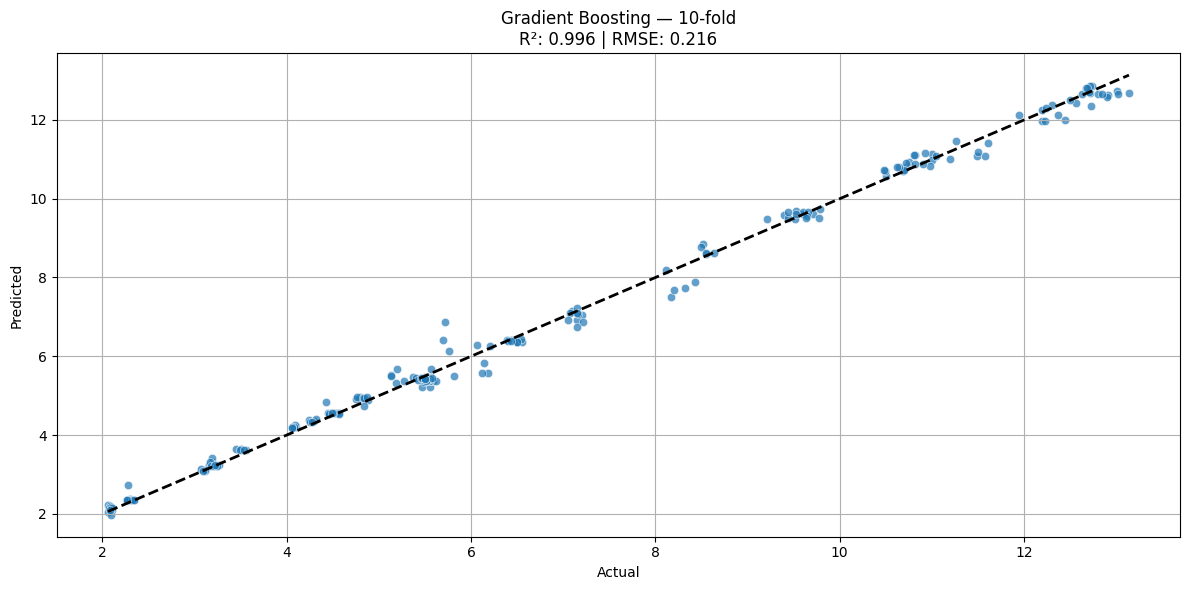

In [32]:
results["GradientBoosting"] = evaluate_kfold(X_encoded , y_encoded , GradientBoostingRegressor(), "Gradient Boosting")

XGBoost 10-fold: 100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


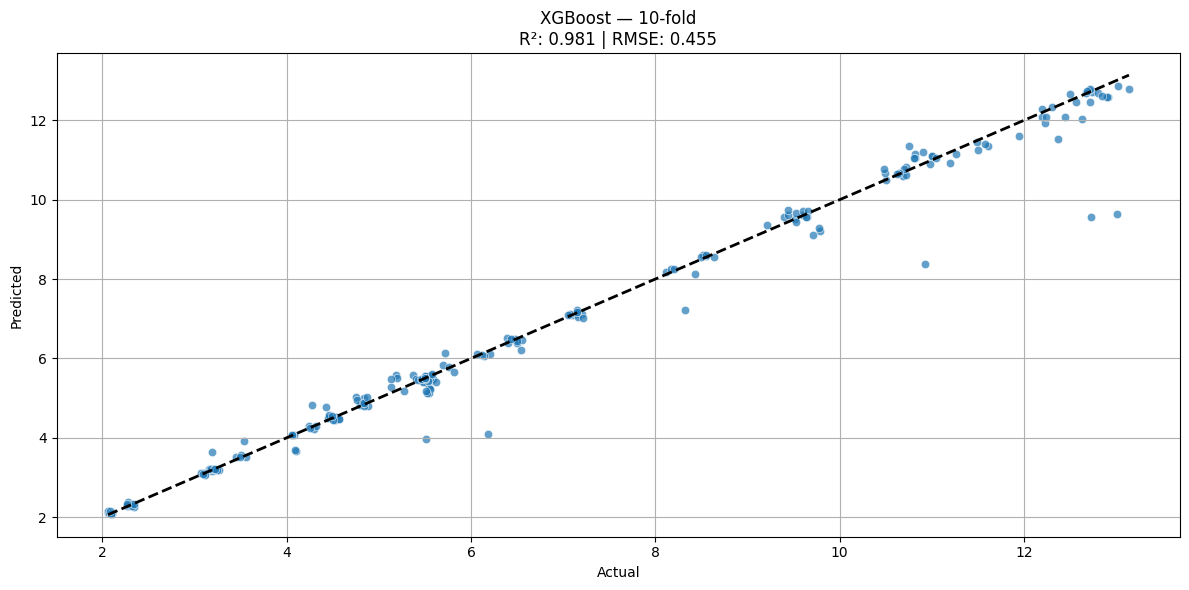

In [33]:
results["XGBoost"] = evaluate_kfold(X_encoded , y_encoded , XGBRegressor(), "XGBoost")

CatBoost 10-fold: 100%|██████████| 10/10 [06:21<00:00, 38.16s/it]


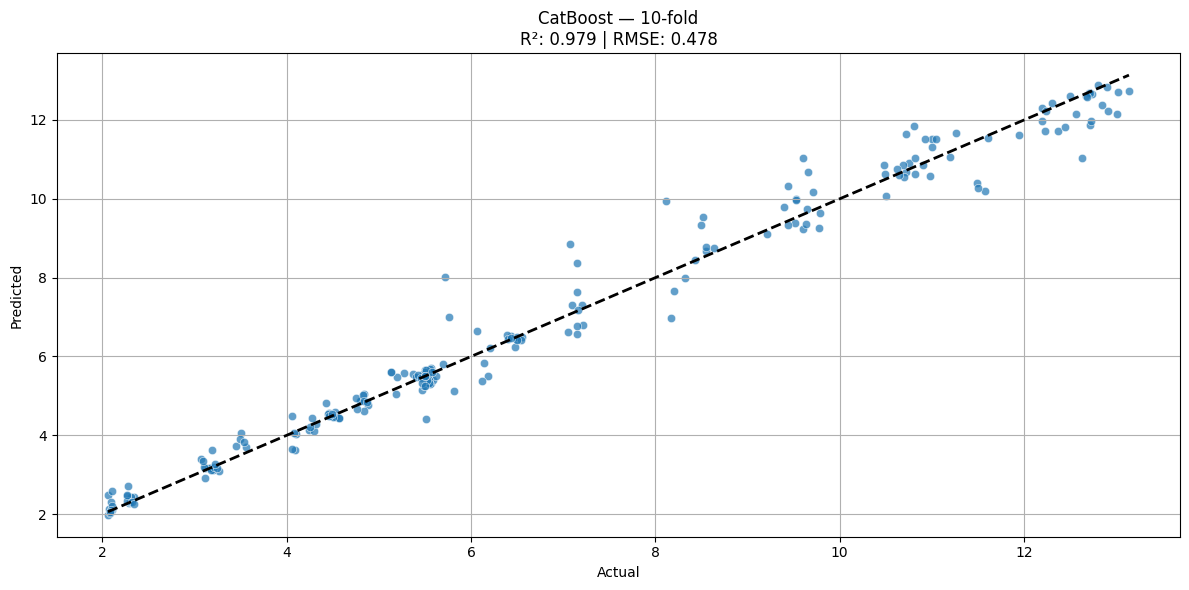

In [34]:
results["CatBoost"] = evaluate_kfold(X_catboost, y_catboost, 
                                              CatBoostRegressor(), 
                                              "CatBoost",
                                              cat_features=catboost_features)

In [35]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['R2', 'MAE'])
df_results = df_results.reset_index().rename(columns={'index': 'Model'})
df_results = df_results.sort_values(by='R2', ascending=False)
df_results 

,Model,R2,MAE
0,LinearRegression,0.999109,0.029850
1,SVR,0.999071,0.030484
3,GradientBoosting,0.995783,0.216085
2,RandomForest,0.993292,0.272551
4,XGBoost,0.981290,0.455175
5,CatBoost,0.979393,0.477691


По таблице видно, что на данных простые модели лучше всего. Линейная регрессия и SVR показывают практически идеальные R² ≈ 0.999 и очень малые средние абсолютные ошибки (MAE ≈ 0.03). Это говорит о том, что зависимость в ваших данных почти линейная и хорошо описывается базовой моделью без необходимости в сложных ансамблях.

Ансамблевые методы (GradientBoosting, RandomForest) тоже справляются неплохо, с R² от 0.995 до 0.993, но их MAE уже на порядок выше (~0.2–0.27). А XGBoost и CatBoost оказались ещё менее точны (R² ≈ 0.98, MAE ≈ 0.45–0.48), что может указывать на избыточную сложность при малом объёме или сильной линейности данных.

Вывод: для задач достаточно использовать простую линейную модель (или SVR) — она даст максимальную точность и минимальную ошибку при минимальных вычислительных затратах.